# Wild Edible Plants Classifier

In [1]:
import numpy as np

from functions.model import Classifier
from functions.plotting import Plotter
from functions.utils import Utilities

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision.models as models

%matplotlib inline

In [2]:
# Run once if permission error when training
# torch.hub.list('pytorch/vision:v0.8.0', force_reload=True)

In [3]:
# Set hyperparameters
epochs = 20
learning_rate = 0.001
batch_size = 64 # samples per batch to load
split_size = 0.15 # validation & test dataset size
h_layers = [512, 256]
n_classes = 35
n_preds = 5 # number of model predictions (e.g. top-5 error rate)
main_filepath = 'dataset/resized'
sample_filepath = 'dataset/sample'
seed = 1

# 1. Data Preparation

## 1.1 Visualize Plant Classes

In [4]:
# Load sample of data with basic transforms
sample_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(400),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
sample = torchvision.datasets.ImageFolder(sample_filepath,
                                          transform=sample_transform)
print(sample)

Dataset ImageFolder
    Number of datapoints: 35
    Root location: dataset/sample
    StandardTransform
Transform: Compose(
               Resize(size=400, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(400, 400))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [5]:
# Create global class labels
labels = np.array(list(sample.class_to_idx), dtype=object)

# Set Plotter and Helper class objects
vis = Plotter(labels)
utils = Utilities()

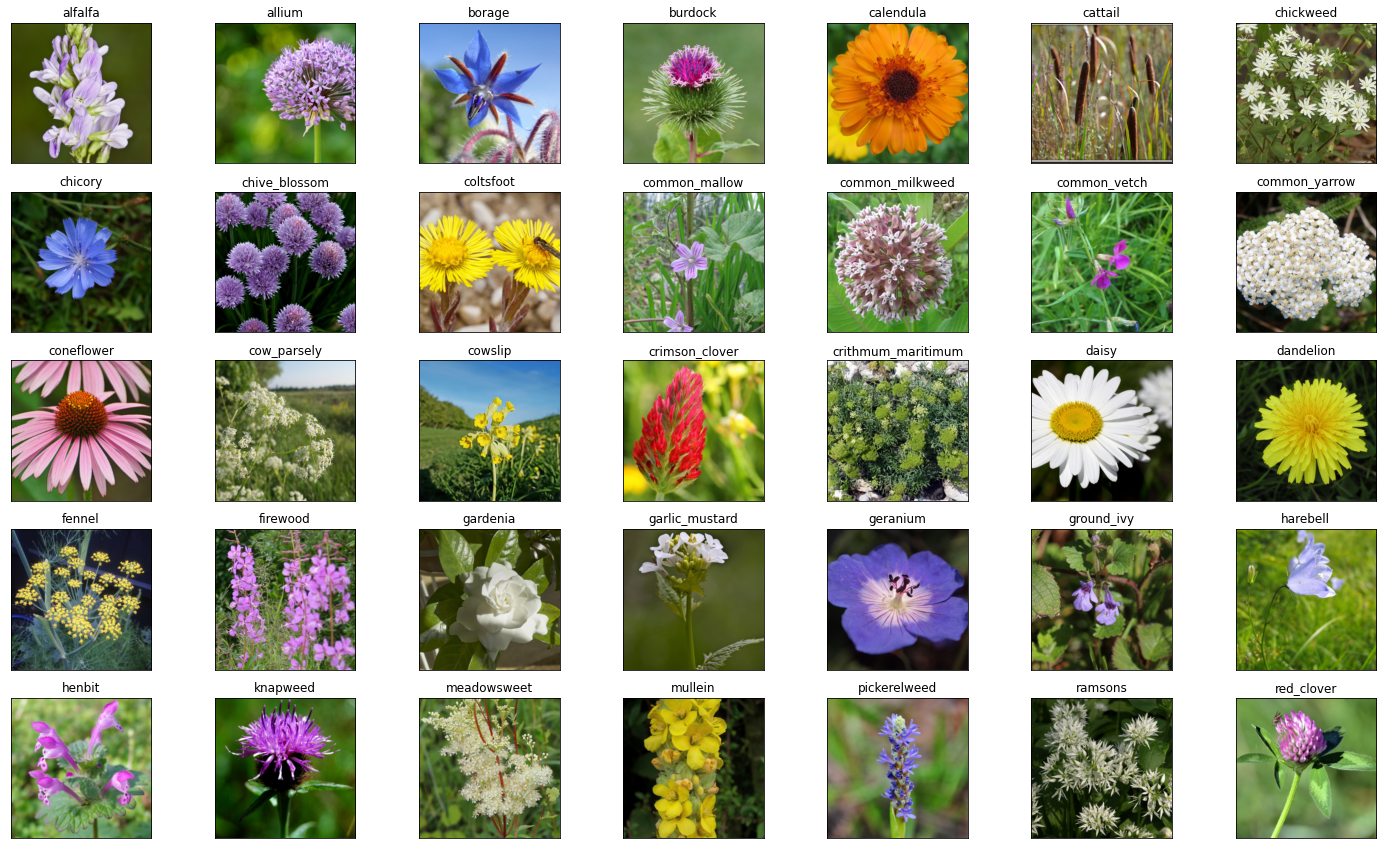

In [6]:
# Obtain the batch of images (full sample)
sample_loader = torch.utils.data.DataLoader(sample, batch_size=labels.size)
sample_iter = iter(sample_loader)
s_img, s_label = sample_iter.next()
s_img = s_img.numpy() # Convert to numpy so can display

# Visualize each class
vis.visualize_imgs(s_img, s_label)

# Save plot
# fig.savefig("class_sample.png")

# 2. Data Segregation

## 2.1 Data Augmentation

In [7]:
# Set transformations for batch data
transform = transforms.Compose([
    transforms.Resize(224), # Resize images to 224
    transforms.CenterCrop(224), # Make images 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip some samples (50% chance)
    transforms.RandomRotation(20), # Randomly rotate some samples
    transforms.ToTensor(), # Convert image to a tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Normalize image values
])

# Get the data
dataset = torchvision.datasets.ImageFolder(main_filepath,
                                              transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 16526
    Root location: dataset/resized
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## 2.2 Split the Data

In [8]:
# Split data
train_loader, valid_loader, test_loader = utils.split_data(dataset, batch_size, 
                                                           split_size, seed)

## 2.3 Visualize a Batch of Training Data

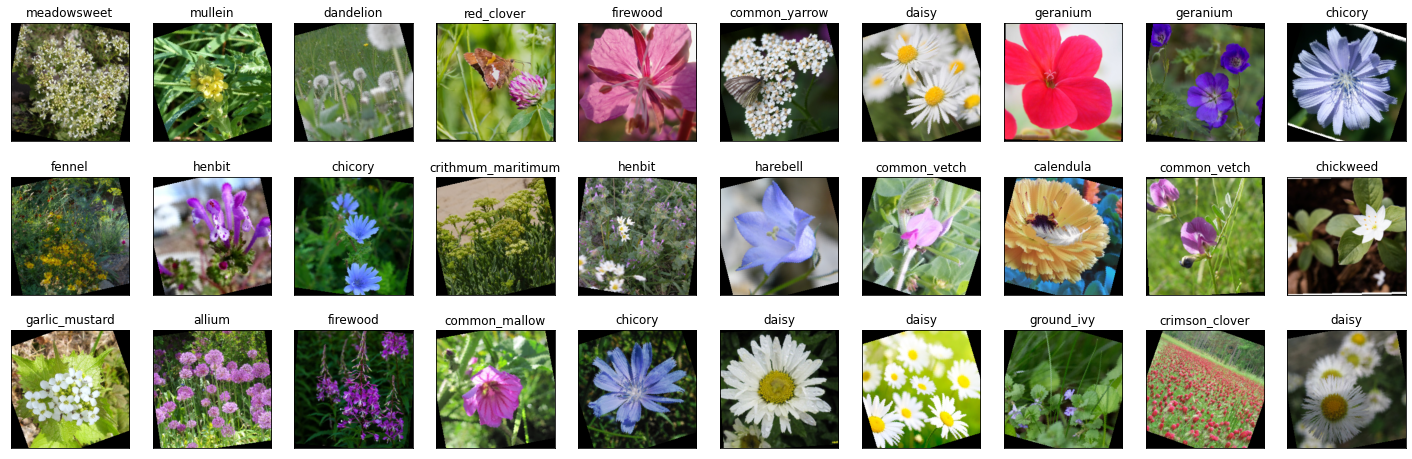

In [9]:
# Obtain the batch of images
train_iter = iter(train_loader)
imgs, lbls = train_iter.next()
imgs = imgs.numpy() # Convert to numpy so can display

# Visualize each class
vis.visualize_imgs(imgs, lbls, figsize=(25, 8), num_rows=3, num_cols=30)

# 3. Model Training

## 3.1 Create CNN Architectures
As the dataset used is small and contains similarities to the ImageNet database, the model itself can be reused. The only adjustment that needs to be made is to add one or two new fully-connected layers to be trained on the wild edible plant dataset.

In [10]:
# Create instances of pretrained CNN architectures
googlenet = models.googlenet(pretrained=True)
mobilenetv2 = models.mobilenet_v2(pretrained=True)
resnet34 = models.resnet34(pretrained=True)

Next it is important to check the layers of the architectures to understand the naming of the ending layers. Taking those names we can then add in the new layers for training the dataset.

In [11]:
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
mobilenetv2

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [13]:
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Initialize new classifiers
gnet_classifier = Classifier(in_features=googlenet.fc.in_features, out_features=n_classes, 
                             hidden_layers=h_layers)
mobilenet_classifier = Classifier(in_features=mobilenetv2.classifier[1].in_features, 
                                  out_features=n_classes, hidden_layers=h_layers)
resnet_classifier = Classifier(in_features=resnet34.fc.in_features, out_features=n_classes, 
                               hidden_layers=h_layers)
print("GoogLeNet",gnet_classifier)
print("\nMobileNet",mobilenet_classifier)
print("\nResNet",resnet_classifier)

GoogLeNet Classifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=35, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

MobileNet Classifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=35, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

ResNet Classifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=35, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## 3.2 Update CNN Architectures

In [15]:
# Set models and model names as lists
model_names = ["GoogleNet", "MobileNet v2", "ResNet-34"]
models = [googlenet, mobilenetv2, resnet34]

In [16]:
# Freeze architecture parameters to avoid backpropagating them
# Avoiding replacing pretrained weights
for model in models:
    for param in model.parameters():
        param.requires_grad = False

In [17]:
# Replace last FC layer for GoogLeNet with new classifier
googlenet.fc = gnet_classifier
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [18]:
# Replace classifier with new one
mobilenetv2.classifier = mobilenet_classifier
mobilenetv2

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [19]:
resnet34.fc = resnet_classifier
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Total params for each model
for idx, model in enumerate(models):
    print(f"{model_names[idx]}:")
    model.total_params = sum(p.numel() for p in model.parameters())
    print(f'{model.total_params:,} total parameters')
    model.trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{model.trainable_params:,} training parameters\n')

GoogleNet:
6,265,027 total parameters
665,123 training parameters

MobileNet v2:
3,020,067 total parameters
796,195 training parameters

ResNet-34:
21,687,651 total parameters
402,979 training parameters



## 3.3 Initial Training of CNN Models

In [21]:
# Set to GPU if available
device = utils.set_device()

CUDA is available. Device has been set to GPU.


In [23]:
# Train GoogLeNet
# Reminder: only target fc parameters (rest are frozen)
googlenet.to(device) # move to GPU
save_filepath = "saved_models/GoogleNet_64_512_256.pt"

# Set loss function and optimizer
criterion = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=learning_rate)

utils.train(googlenet, train_loader, valid_loader, criterion, 
            optimizer, save_filepath, epochs)

Epoch: 1/20 Step: 90/180 Training Loss: 2.813 Validation Loss: 1.827 Accuracy: 0.472
Validation loss decreased (inf -> 1.827). Saving model...
Epoch: 1/20 Step: 180/180 Training Loss: 1.776 Validation Loss: 1.383 Accuracy: 0.590
Validation loss decreased (1.827 -> 1.383). Saving model...
Epoch: 2/20 Step: 90/180 Training Loss: 1.465 Validation Loss: 1.112 Accuracy: 0.670
Validation loss decreased (1.383 -> 1.112). Saving model...
Epoch: 2/20 Step: 180/180 Training Loss: 1.336 Validation Loss: 1.082 Accuracy: 0.698
Validation loss decreased (1.112 -> 1.082). Saving model...
Epoch: 3/20 Step: 90/180 Training Loss: 1.227 Validation Loss: 0.985 Accuracy: 0.712
Validation loss decreased (1.082 -> 0.985). Saving model...
Epoch: 3/20 Step: 180/180 Training Loss: 1.154 Validation Loss: 0.895 Accuracy: 0.740
Validation loss decreased (0.985 -> 0.895). Saving model...
Epoch: 4/20 Step: 90/180 Training Loss: 1.097 Validation Loss: 0.898 Accuracy: 0.743
Early stopping counter: 1/5.
Epoch: 4/20 Ste

In [24]:
# Train MobileNet V2
# Reminder: only target classifier parameters (rest are frozen)
mobilenetv2.to(device) # move to GPU
save_filepath = "saved_models/MobileNet-V2_64_512_256.pt"

# Set loss function and optimizer
criterion = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = torch.optim.Adam(mobilenetv2.classifier.parameters(), lr=learning_rate)

utils.train(mobilenetv2, train_loader, valid_loader, criterion, 
            optimizer, save_filepath, epochs)

Epoch: 1/20 Step: 90/180 Training Loss: 2.489 Validation Loss: 1.280 Accuracy: 0.659
Validation loss decreased (inf -> 1.280). Saving model...
Epoch: 1/20 Step: 180/180 Training Loss: 1.311 Validation Loss: 0.940 Accuracy: 0.741
Validation loss decreased (1.280 -> 0.940). Saving model...
Epoch: 2/20 Step: 90/180 Training Loss: 1.074 Validation Loss: 0.766 Accuracy: 0.779
Validation loss decreased (0.940 -> 0.766). Saving model...
Epoch: 2/20 Step: 180/180 Training Loss: 0.947 Validation Loss: 0.681 Accuracy: 0.804
Validation loss decreased (0.766 -> 0.681). Saving model...
Epoch: 3/20 Step: 90/180 Training Loss: 0.866 Validation Loss: 0.661 Accuracy: 0.811
Validation loss decreased (0.681 -> 0.661). Saving model...
Epoch: 3/20 Step: 180/180 Training Loss: 0.844 Validation Loss: 0.704 Accuracy: 0.805
Early stopping counter: 1/5.
Epoch: 4/20 Step: 90/180 Training Loss: 0.779 Validation Loss: 0.691 Accuracy: 0.801
Early stopping counter: 2/5.
Epoch: 4/20 Step: 180/180 Training Loss: 0.753

In [25]:
# Train ResNet-34
# Reminder: only target fc parameters (rest are frozen)
resnet34.to(device) # move to GPU
save_filepath = "saved_models/ResNet-34_64_512_256.pt"

# Set loss function and optimizer
criterion = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = torch.optim.Adam(resnet34.fc.parameters(), lr=learning_rate)

utils.train(resnet34, train_loader, valid_loader, criterion, 
            optimizer, save_filepath, epochs)

Epoch: 1/20 Step: 90/180 Training Loss: 2.642 Validation Loss: 1.465 Accuracy: 0.596
Validation loss decreased (inf -> 1.465). Saving model...
Epoch: 1/20 Step: 180/180 Training Loss: 1.444 Validation Loss: 1.026 Accuracy: 0.701
Validation loss decreased (1.465 -> 1.026). Saving model...
Epoch: 2/20 Step: 90/180 Training Loss: 1.166 Validation Loss: 0.911 Accuracy: 0.730
Validation loss decreased (1.026 -> 0.911). Saving model...
Epoch: 2/20 Step: 180/180 Training Loss: 1.076 Validation Loss: 0.839 Accuracy: 0.751
Validation loss decreased (0.911 -> 0.839). Saving model...
Epoch: 3/20 Step: 90/180 Training Loss: 0.959 Validation Loss: 0.775 Accuracy: 0.777
Validation loss decreased (0.839 -> 0.775). Saving model...
Epoch: 3/20 Step: 180/180 Training Loss: 0.964 Validation Loss: 0.780 Accuracy: 0.773
Early stopping counter: 1/5.
Epoch: 4/20 Step: 90/180 Training Loss: 0.867 Validation Loss: 0.722 Accuracy: 0.782
Validation loss decreased (0.775 -> 0.722). Saving model...
Epoch: 4/20 Ste

# 4. Performance Evaluation

In [26]:
# Calculate predictions, test labels, and probabilities
model_preds, model_trues, model_probas = [], [], []
for i in range(len(models)):
    y_pred, y_true, y_probas = utils.predict(models[i], test_loader, 
                                             store_labels=True, 
                                             store_probas=True)
    model_preds.append(y_pred)
    model_trues.append(y_true)
    model_probas.append(y_probas)

In [29]:
# Load saved models
utils.load_model(googlenet, "saved_models/GoogleNet_64_512_256.pt")
utils.load_model(mobilenetv2, "saved_models/MobileNet-V2_64_512_256.pt")
utils.load_model(resnet34, "saved_models/ResNet-34_64_512_256.pt")

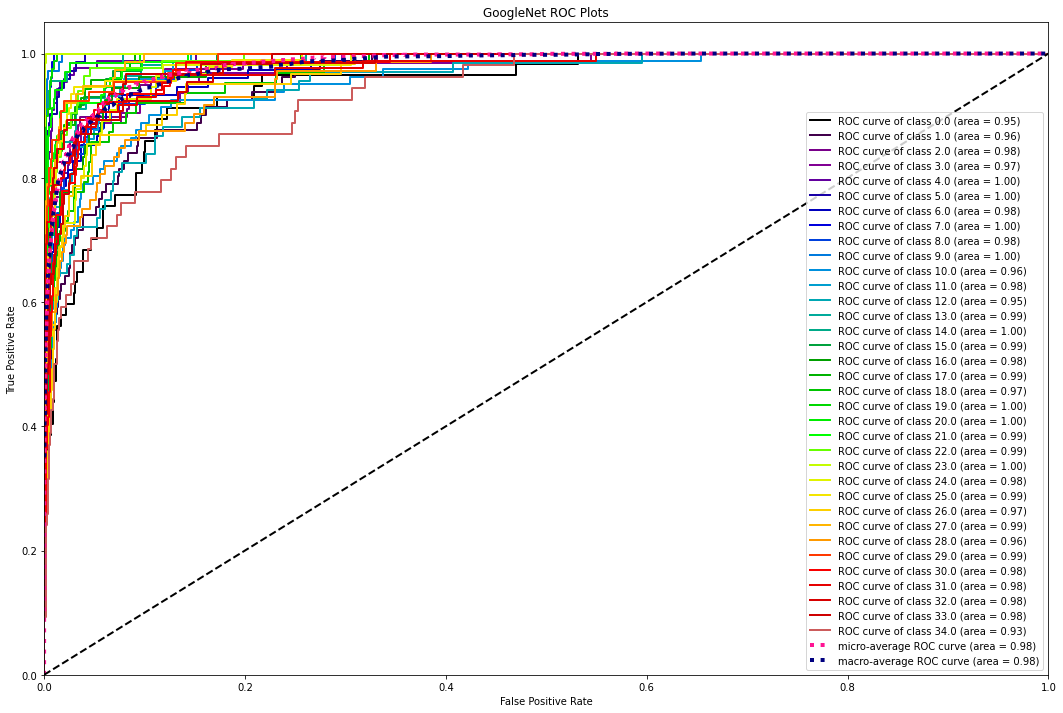

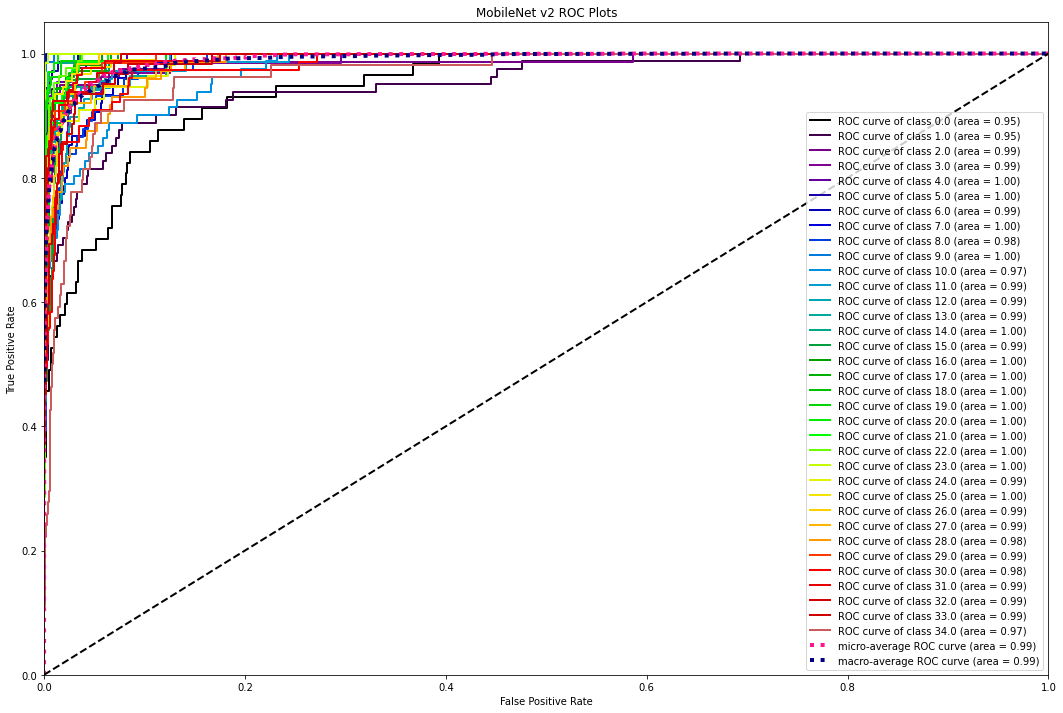

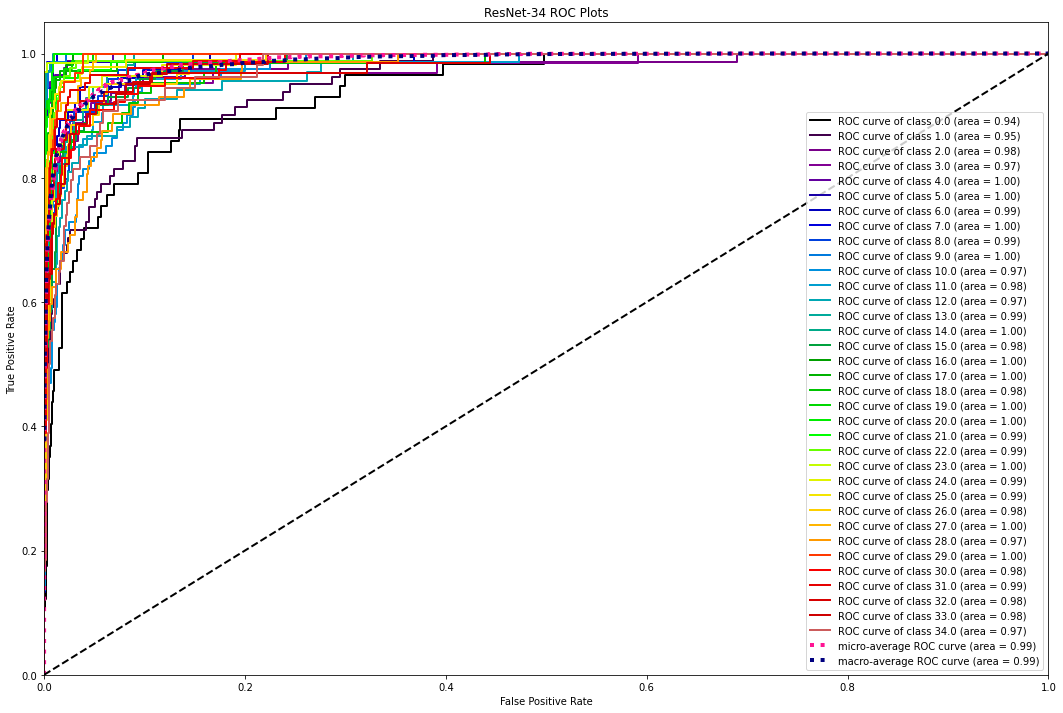

In [31]:
# Plot ROC curves
for i in range(len(models)):
    vis.plot_roc(models[i], model_names[i], model_probas[i], 
                 model_trues[i], figsize=(18, 12))

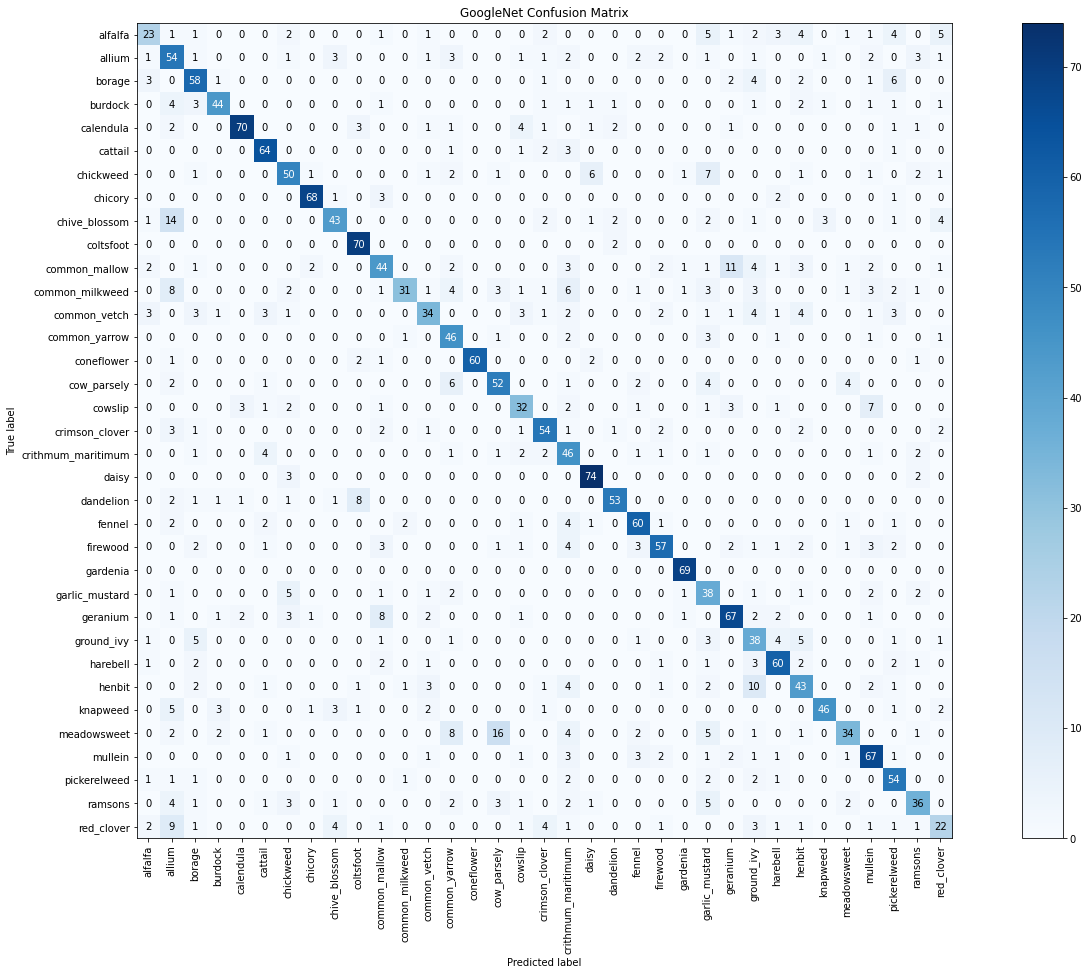

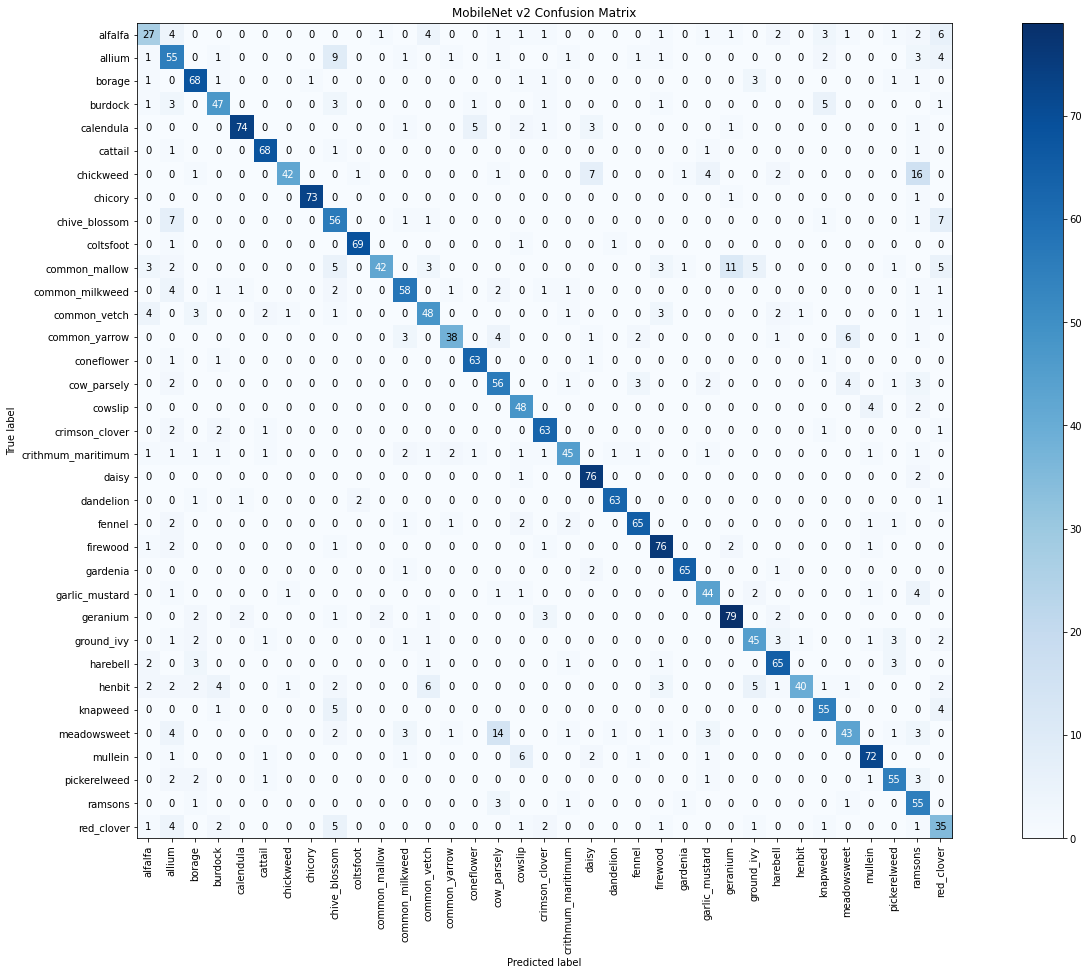

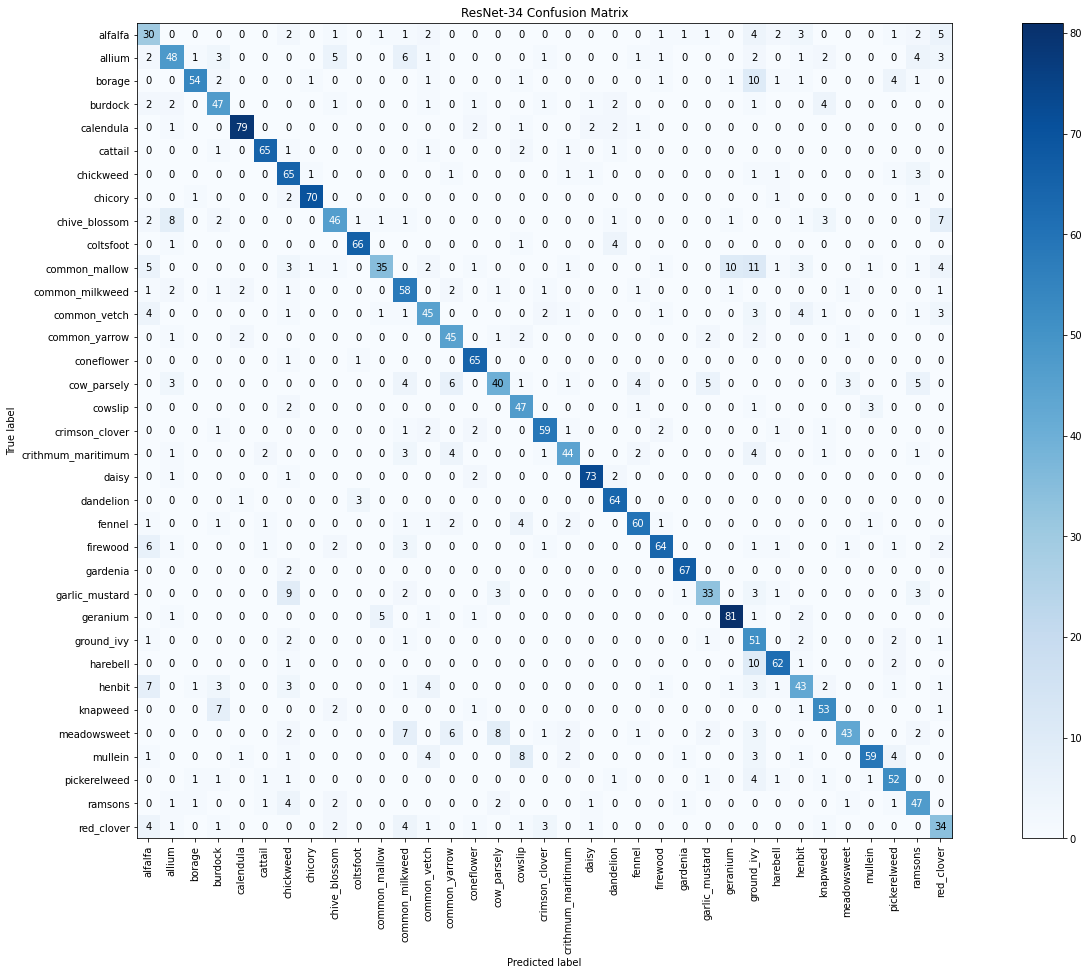

In [32]:
# Plot Confusion Matrices
for i in range(len(models)):
    y_pred_cm, y_true_cm = utils.indices_to_labels(model_preds[i], model_trues[i], labels)
    vis.plot_cm(models[i], model_names[i], y_pred_cm, y_true_cm)

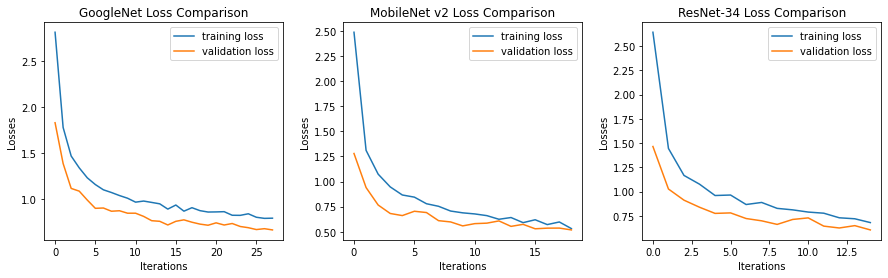

In [33]:
# Plot loss comparsion
vis.create_plots(models, model_names, figsize=(15, 4), plot_func=vis.plot_losses,
                 plot_name="valid_model_losses", save=False)

# 5. Hyperparameter Tuning
Please refer to the Jupyter Notebook `2. wep_classifier_tuning.ipynb` for this section.